In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV # using Randomized Search instead of Grid Search 
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix



import warnings
warnings.filterwarnings('ignore')

In [26]:
# Load dataset and check proportion of class imbalance
heart_disease = pd.read_csv(r'C:\Users\hp\Downloads\heart_statlog_cleveland_hungary_final.csv')
print(heart_disease['target'].value_counts())

target
1    629
0    561
Name: count, dtype: int64


## Data Assessment

In [27]:
def assess(data):
    ''' Checks the basic data assessment protocol'''
    print(f'Number of duplicates: {data.duplicated().sum()} \n')
    print(f"Null Values \n{data.isnull().sum()}")
    if data.duplicated().sum() > 0:
        data.drop_duplicates(inplace = True) # drop occurence of duplicate records
    else:
        print("There are no duplicates")
    return data

assess(heart_disease)

Number of duplicates: 272 

Null Values 
age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,45,1,1,110,264,0,0,132,0,1.2,2,1
1186,68,1,4,144,193,1,0,141,0,3.4,2,1
1187,57,1,4,130,131,0,0,115,1,1.2,2,1
1188,57,0,2,130,236,0,2,174,0,0.0,2,1


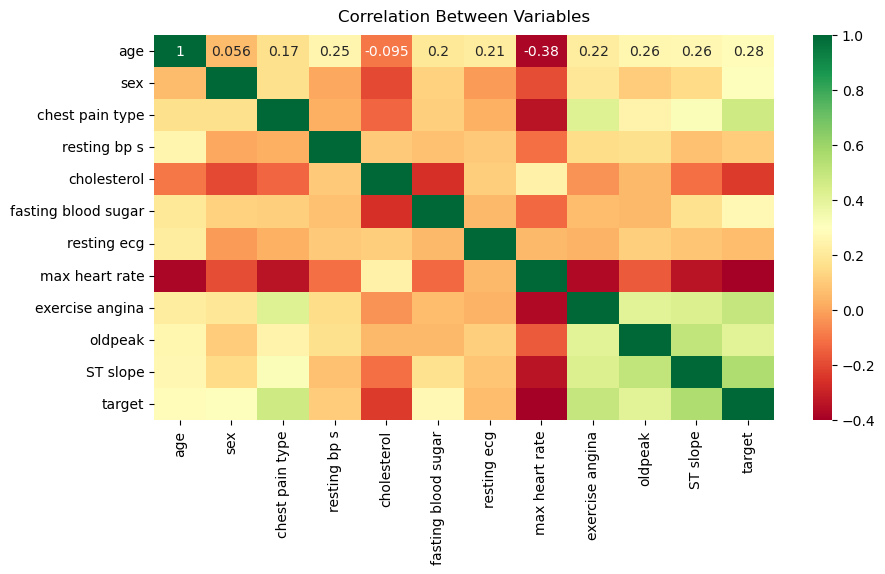

In [25]:
# plotting correlation
plt.figure(figsize=(10,5))
sns.heatmap(heart_disease.corr(), annot=True, cmap="RdYlGn")
plt.title('Correlation Between Variables', pad = 10)
plt.show()

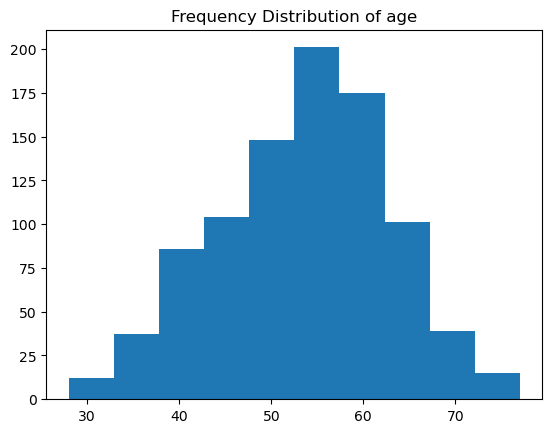

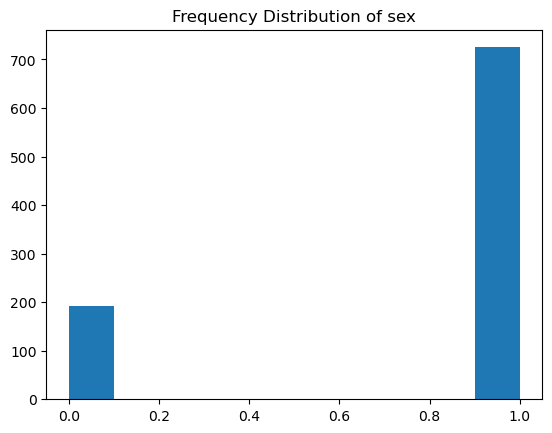

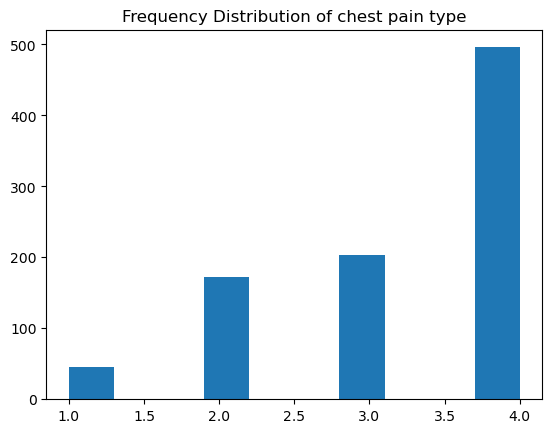

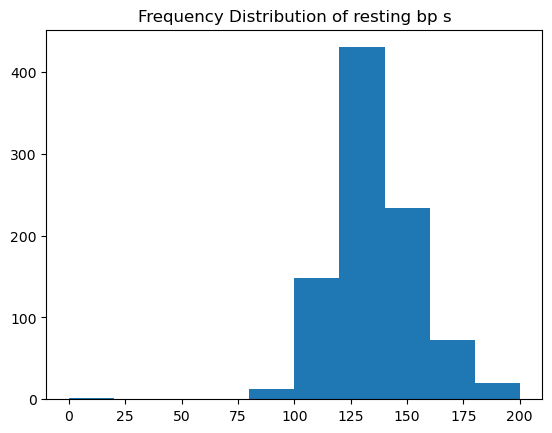

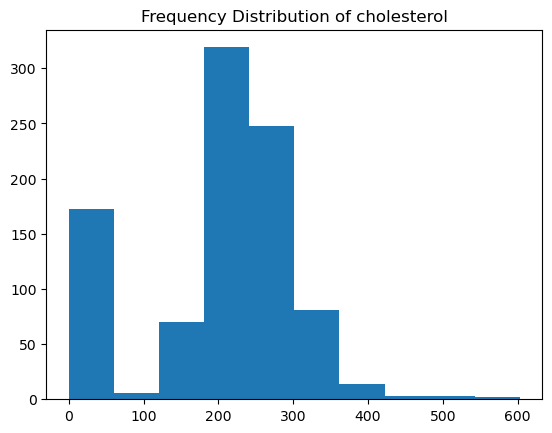

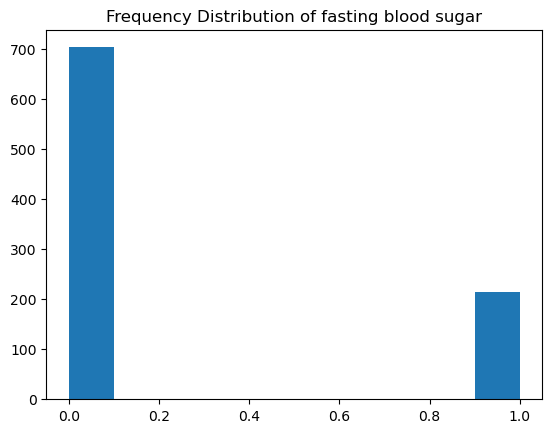

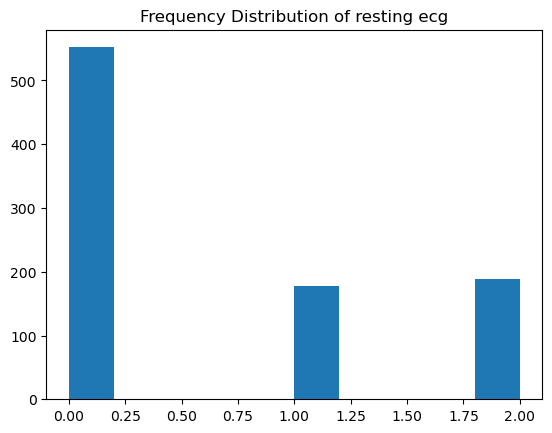

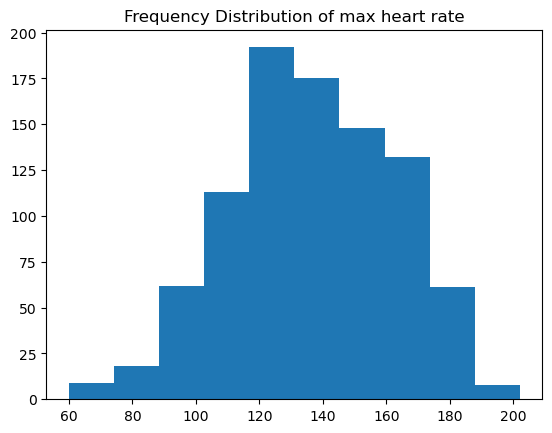

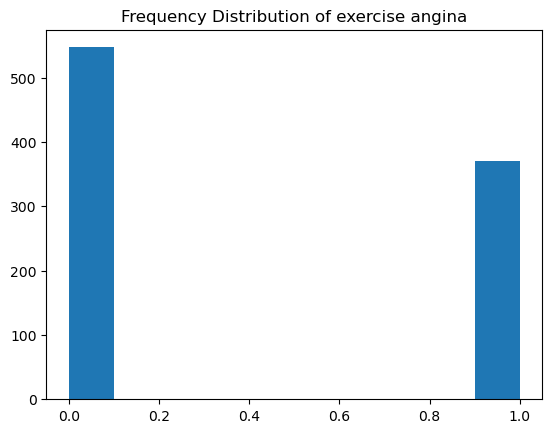

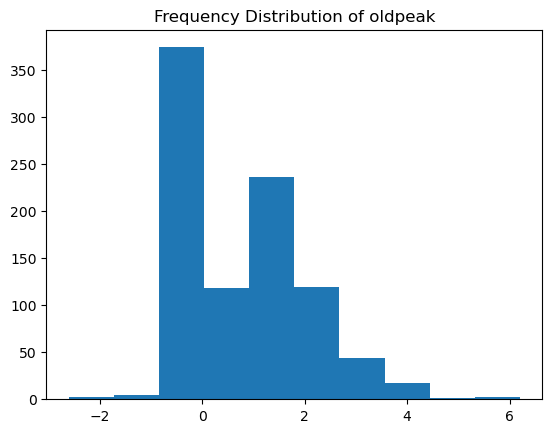

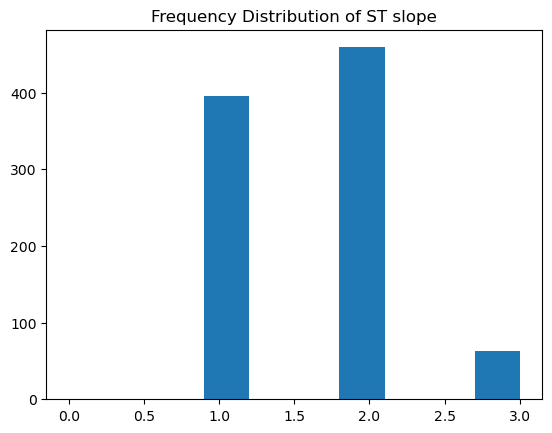

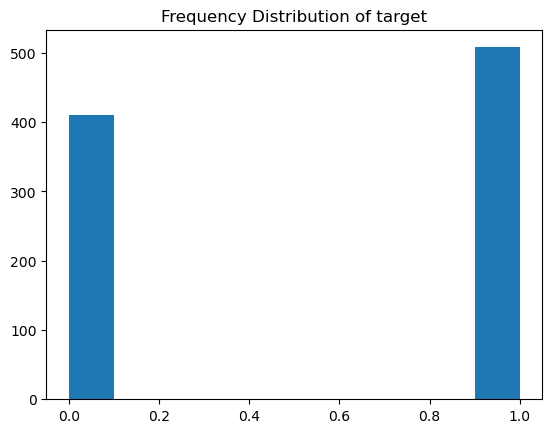

In [29]:
# check distribution of the variables
for col in heart_disease.select_dtypes(include = (int, float)):
    plt.hist(heart_disease[col])
    plt.title(f'Frequency Distribution of {col}')
    plt.show() 

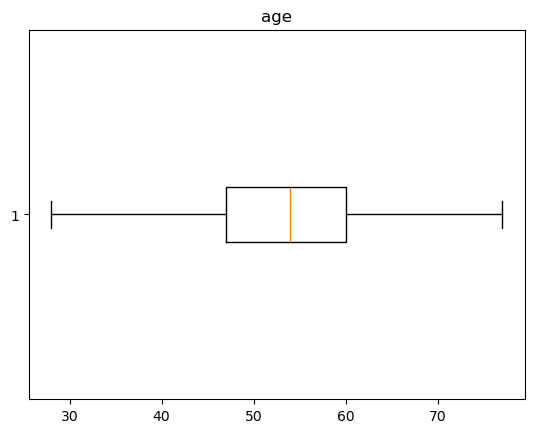

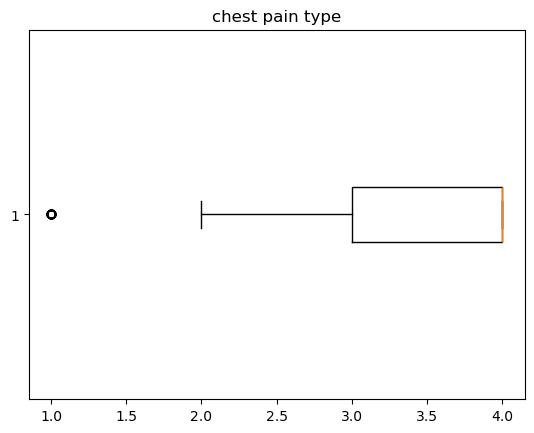

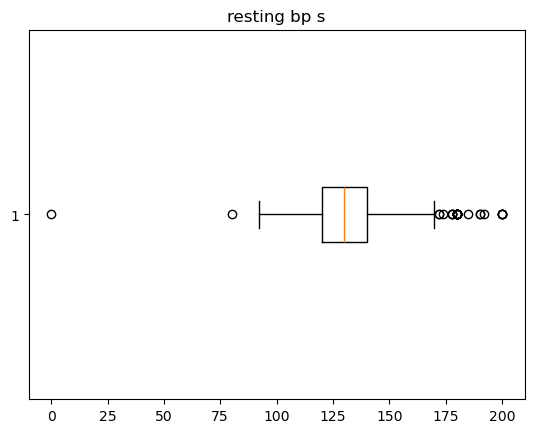

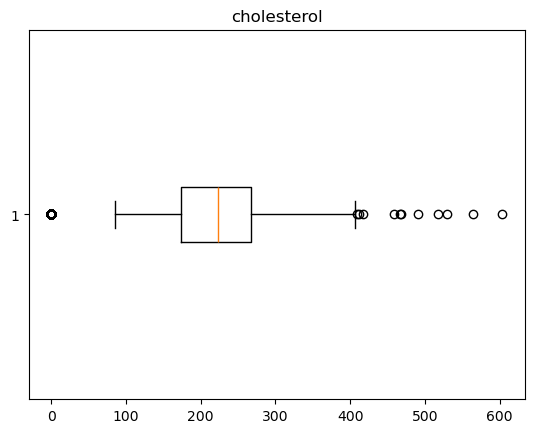

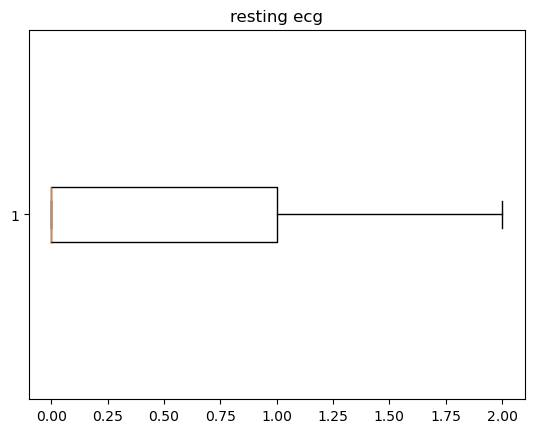

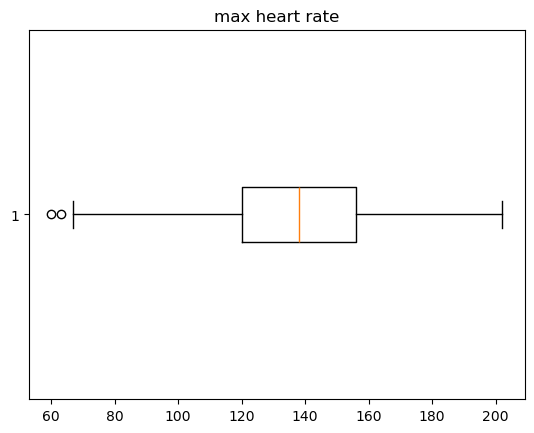

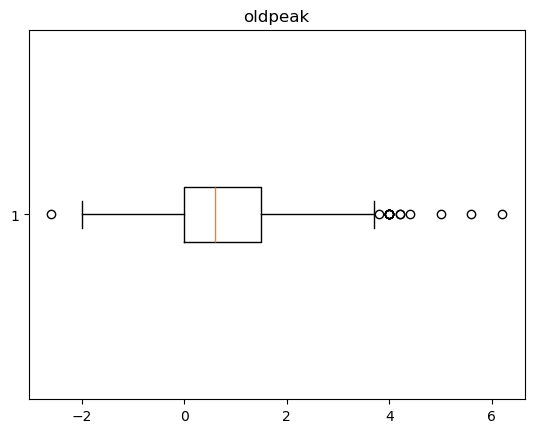

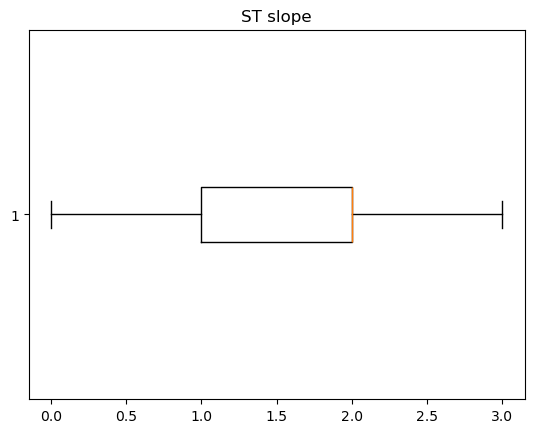

In [43]:
def check_outliers(data):
    '''checks outliers but for none binary data'''
    for column in data.columns.tolist():
        if data[column].isin([0, 1]).all():
            continue

        plt.boxplot(data[column], vert = False)
        plt.title(column)
        plt.show()

check_outliers(heart_disease)
        

### No presence of significant outliers. Some of the columns like Chest Pain, resting ecg and ST slope are nominal data having distinct categories. Meanwhile resting bp column have significant outlier, and replacing the outliers with the trimmed mean or median will be the most appropriate approach in this case.

In [45]:
def eliminate_outlier(data, column):
    '''calculate and replaces outlier with median value'''
    q1, q3 = np.percentile(data[column], [25, 75])
    IQR = q3 - q1

    lower_bound = q1 - 3 * IQR
    upper_bound = q3 + 3 * IQR
    data.loc[(data[column] < lower_bound) | (data[column] > upper_bound), column] = data[column].median() # replace with median

eliminate_outlier(heart_disease, 'resting bp s')

<Axes: >

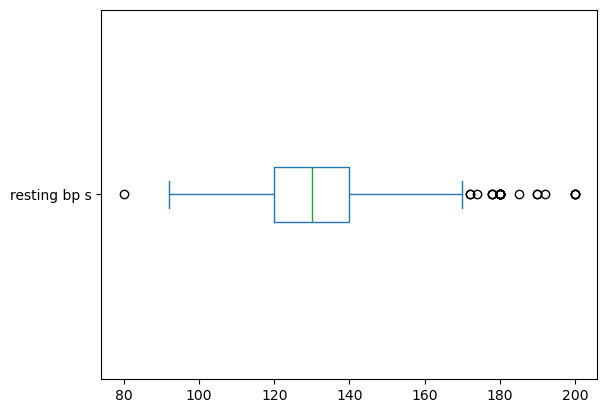

In [47]:
heart_disease['resting bp s'].plot(kind = 'box', vert = False) # check that outlier is removed

## Exploratory Data Analysis

### The basis of this EDA is to  determine possible features or characteristics that patient with heart disease possess but not seen in patient without heart disease. 

#### 1: Identify Patients with Heart Disease by Age and Sex

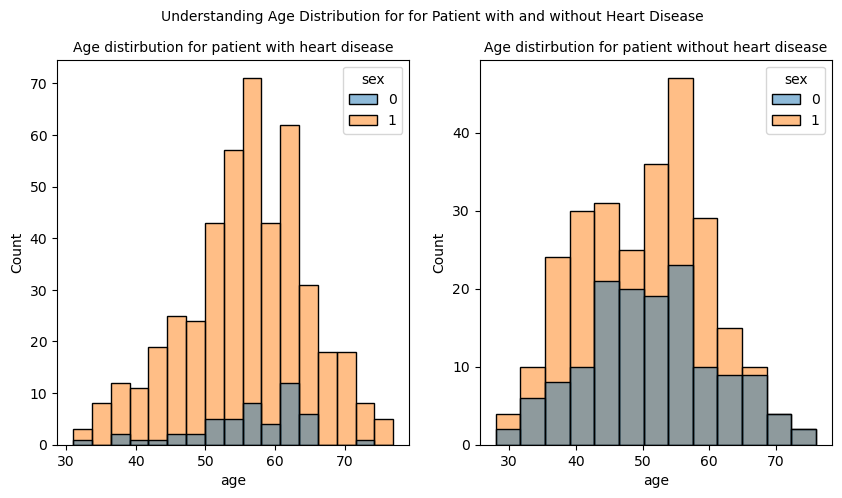

In [77]:
target_1 = heart_disease[heart_disease['target'] == 1]
target_0 = heart_disease[heart_disease['target'] == 0]

fig, ax = plt.subplots(1,2, figsize = (10,5))
fig.suptitle('Understanding Age Distribution for for Patient with and without Heart Disease', size = 10)
sns.histplot(data = target_1, x = 'age', hue ='sex', ax = ax[0])
ax[0].set_title('Age distirbution for patient with heart disease', size = 10)

sns.histplot(data = target_0, x = 'age', hue ='sex', ax = ax[1])
ax[1].set_title('Age distirbution for patient without heart disease', size = 10)

plt.show()

It makes sense that huge part of heart disease are seen in the male counterpart mostly between age 50 and 65 as compared to females.

### 2: Comparing variables to understand potential causes or features attributed to heart disease.

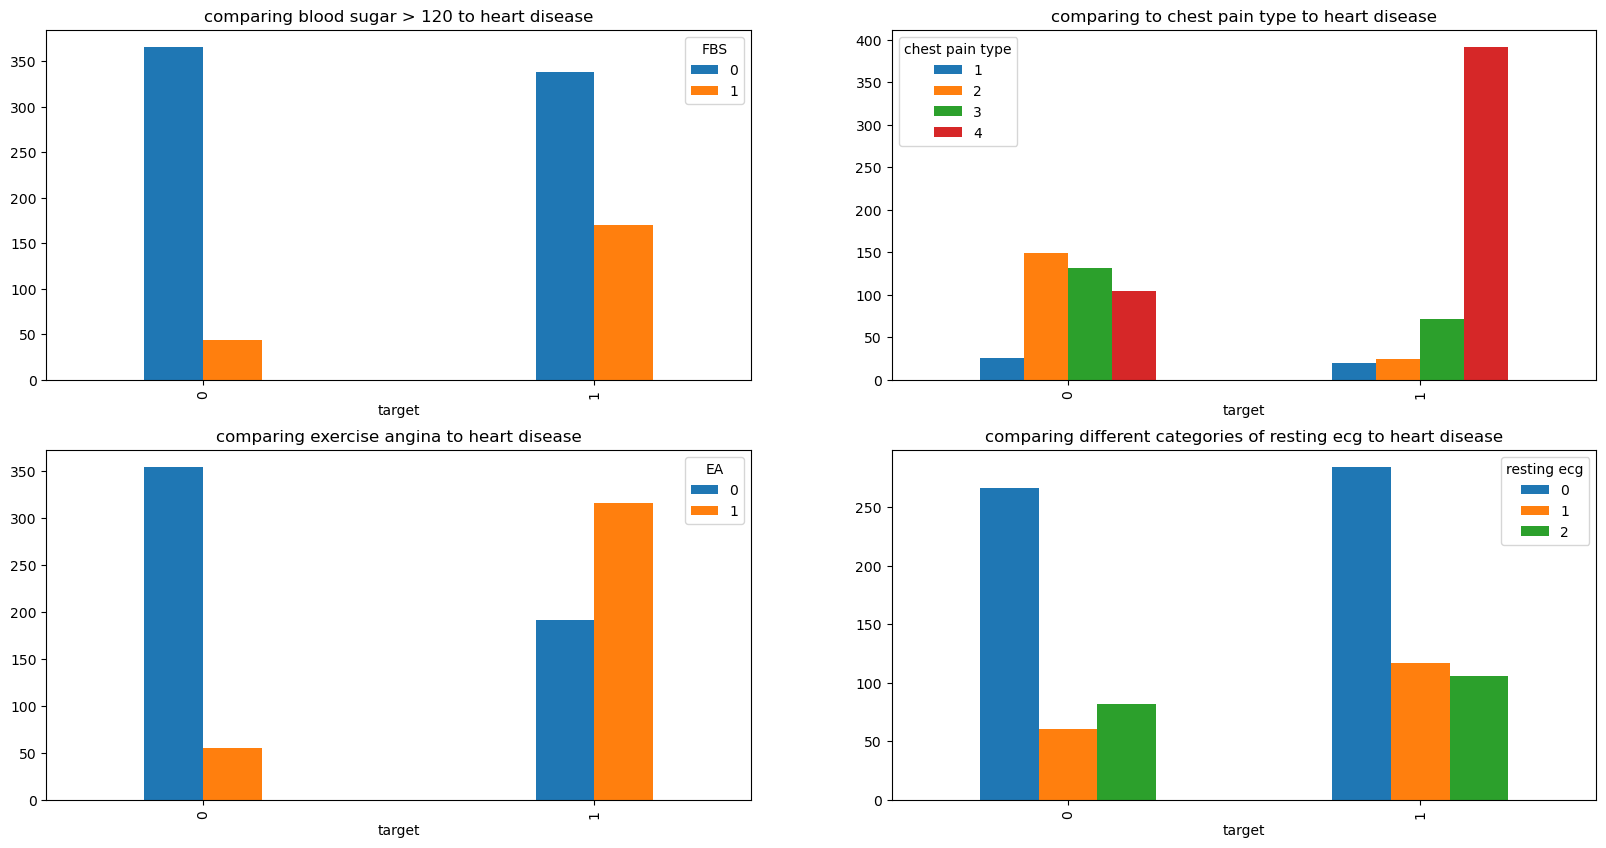

In [118]:
fig, ax = plt.subplots(2,2, figsize = (20, 10))

fbs_distri = pd.crosstab(heart_disease['target'], heart_disease['fasting blood sugar']).plot(kind = 'bar', width = 0.3, ax = ax[0,0])
ax[0,0].legend(title = 'FBS')
ax[0,0].set_title('comparing blood sugar > 120 to heart disease')

fbs_distri = pd.crosstab(heart_disease['target'], heart_disease['chest pain type']).plot(kind = 'bar', ax = ax[0,1])
ax[0,1].set_title('comparing to chest pain type to heart disease')

fbs_distri = pd.crosstab(heart_disease['target'], heart_disease['exercise angina']).plot(kind = 'bar', width = 0.3, ax = ax[1,0])
ax[1,0].legend(title = 'EA', loc = 0)
ax[1,0].set_title('comparing exercise angina to heart disease')

fbs_distri = pd.crosstab(heart_disease['target'], heart_disease['resting ecg']).plot(kind = 'bar', ax = ax[1,1])
ax[1,1].set_title('comparing different categories of resting ecg to heart disease')

plt.show()

#### Key Insight:
- There is higher proportion of patient with fbs > 120 having heart disease as compared to patient below 120 not having heart disease.
- Chest pain type 4: Asymptomatic is obviously seen as one of the leading features possessed by an individual with heart disease.
- Having exercise angina is seen as one of the property possessed by a heart disease patient.
- As seen in the chart above, resting ecg might not have a significant impact on whether a patient have heart disease or not as not significant pattern was seen in that case.  

#### Training Model

Fitting 5 folds for each of 20 candidates, totalling 100 fits
===== fold 1 ===== 
0.8125435540069686
===== fold 2 ===== 
0.7839721254355401
===== fold 3 ===== 
0.6619318181818181
===== fold 4 ===== 
0.8386752136752137
Mean Accuracy: 0.7742806778248852
Train Set Accuracy: 0.8879551820728291
[[29  7]
 [ 5 34]]


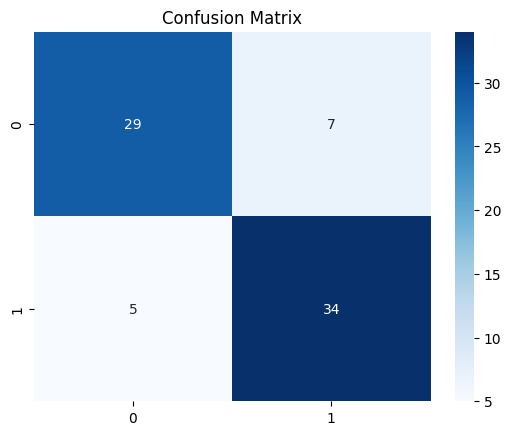

In [10]:
# Training xgboost
param_grid = {   # defining parameters to find best parameters
    'n_estimators': [50, 100, 200],
    'learning_rate':[0.01, 0.1, 0.2],
    'max_depth':[3, 5, 7],
    'gamma':[0, 0.1, 0.2],
    'scale_pos_weight':[1,2,5]}  


random_search = RandomizedSearchCV(    # using randomizedsearchCV to find the best parameters for the XGB model 
    estimator= XGBClassifier(), param_distributions=param_grid, n_iter=20, cv=5, random_state=42,
    verbose=2, n_jobs=-1  # Utilize all CPU cores
)

random_search.fit(X, y) # fitting dataset 
best_params = random_search.best_params_ # getting the best parameters
kfold = KFold(n_splits= 4, shuffle=True, random_state=42) # creating an instance of kfold cross validation

model = XGBClassifier(**best_params, objective='binary:logistic', random_state = 42) # creating an instance of xgboost model

count = 0 # initialize count to count number of folds 
# using for loop, split into test and train set for the dependent and independent variable, make predictions and print accuracy 
kfold_score = []
for train_index, test_index in kfold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 

    model.fit(X_train, y_train)
    X_pred = model.predict(X_train) # performance on seen data: predicting probability
    train_auc = roc_auc_score(y_train, X_pred)

    y_pred = model.predict(X_test) # performance on unseen data: predicting the probability
    auc = roc_auc_score(y_test, y_pred)
    count += 1
    print(f'===== fold {count} ===== \n{auc}') # using auc evaluation metrics
    kfold_score.append(auc)
print(f"Mean Accuracy: {np.mean(kfold_score)}")
print(f'Train Set Accuracy: {train_auc}')

# compute confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# visualize confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()